In [377]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
from matplotlib.patches import Wedge
from datetime import datetime
import matplotlib.dates as md

In [401]:
# Define constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440 # km
M_M = -200.9 #nT R_M^3

In [529]:
# Define functions

# Load a PDS dataset and return a big numpy array with all the data
def read_mag(path):
    # First, get all the files in the directory
    all_files = [f for f in listdir(path) if isfile(join(path, f))]
    # Then use regex to pick out the .tab file
    for i in all_files:
        match = re.search(".*\.TAB",i)
        if match != None:
            file = str(path+"/"+i)
    colnames=['year','DAY_OF_YEAR','hour','minute','second','TIME_TAG','NAVG','X','Y','Z','B_x','B_y','B_z','DBX','DBY','DBZ']
    df = pd.read_csv(file, delimiter=r"\s+", names=colnames, header=None)
    return df

# Generate plots of orbital path
def plot_orbit(df,start_time,end_time):
    # Select data to plot
    df_slice = df[(df['timestamp']>=start_time) & (df['timestamp']<=end_time)]
    
    # Define figure
    fig, axs = plt.subplots(ncols=2,figsize=(13,5))

    # Define patches for planet
    p0 = plt.Circle((0, 0), 1, color='black')
    p1 = Wedge(0, 0.99, -90, 90, fc='white')
    p2 = plt.Circle((0, 0), 1, color='black')
    p3 = plt.Circle((0, 0), 0.97, color='white')

    # Add planet
    axs[0].add_artist(p0)
    axs[0].add_artist(p1)
    axs[1].add_artist(p2)
    axs[1].add_artist(p3)

    # Plot orbit
    plot0 = axs[0].scatter(df_slice['X']/R_M,df_slice['Z']/R_M,c=df_slice['TIME_TAG'],s=0.5)
    plot1 = axs[1].scatter(df_slice['Y']/R_M,df_slice['Z']/R_M,c=df_slice['TIME_TAG'],s=0.5)
    fig.colorbar(plot0)

    # Overwrite regions where spacecraft is behind planet
    #mask = [df['X']<0]#(df['Y']**2+df['Z']**2<1)]
    #axs[1].scatter(df['Y'][(df['X']<0) & (df['Y']**2+df['Z']**2<10)]/R_M,df['Z'][(df['X']<0) & (df['Y']**2+df['Z']**2<10)]/R_M,color="black",s=0.5)

    # Set axes labels
    axs[0].set_aspect('equal', adjustable='box')
    axs[0].set_xlabel("X [$R_M$]")
    axs[0].set_ylabel("Z [$R_M$]")
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_xlabel("Y [$R_M$]")
    axs[1].set_ylabel("Z [$R_M$]")

    # Set axes limits
    axs[1].set_xlim(-2,2)
    axs[1].set_ylim(-2,2)

    # Save
    plt.savefig("orbit.png")

# All calculations of secondary terms are done here
def calculate_terms(df):
    # Compute spherical coords
    R = np.sqrt(df['X']**2+df['Y']**2+df['Z']**2) # km
    
    # Compute magnetic field strength
    B_mag = np.sqrt(df['B_x']**2+df['B_y']**2+df['B_z']**2) # nT

    # Compute magnetic pressure
    P_mag = B_mag**2/(2*mu_0)*1e-9 # nPa

    # Compute dipole field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
    B_xdip = 3*M_M * df['X']/R_M * df['Z']/R_M/(R/R_M)**5
    B_ydip = 3*M_M * df['Y']/R_M * df['Z']/R_M/(R/R_M)**5
    B_zdip = M_M * (3*df['Z']/R_M**2-(R/R_M)**2)/(R/R_M)**5
    B_dip = np.sqrt(B_xdip**2+B_ydip**2+B_zdip**2)

    # Compute local lat/time
    lat = np.arctan(df['Z']/np.sqrt(df['X']**2+df['Y']**2))*180/np.pi
    phi = np.arctan(df['Y']/df['X'])
    local_time = phi*12/np.pi + 12 

    # Compute timestamp
    year = df['year'].to_numpy()
    daynum = df['DAY_OF_YEAR'].to_numpy()
    month_ls = []
    day_ls = []
    for i in range(len(year)):
        date = datetime.strptime(str(year[i]) + "-" + str(daynum[i]), "%Y-%j").strftime("%m-%d-%Y")
        month_ls.append(date[0:2])
        day_ls.append(date[3:5])

    # Compute gradients:
    # Step through each cell and compute dx,dy,dz. We skip the first cell.
    dx=[0]
    dy=[0]
    dz=[0]
    dBx=[0]
    dBy=[0]
    dBz=[0]
    for i in range(1,len(df)):
        dx.append(df['X'][i]-df['X'][i-1])
        dy.append(df['Y'][i]-df['Y'][i-1])
        dz.append(df['Z'][i]-df['Z'][i-1])
        dBx.append(df['B_x'][i]-df['B_x'][i-1])
        dBy.append(df['B_y'][i]-df['B_y'][i-1])
        dBz.append(df['B_z'][i]-df['B_z'][i-1])
        # Set the 0th element equal to the first
        if i==1:
            dx[0] = dx[i]
            dy[0] = dy[i]
            dz[0] = dz[i]
            dBx[0] = dBx[i]
            dBy[0] = dBy[i]
            dBz[0] = dBz[i]
    
    # Save to df
    df.insert(len(df.columns), "day",day_ls)
    df.insert(len(df.columns), "month",month_ls)
    df.insert(len(df.columns), "lat",lat)
    df.insert(len(df.columns), "local_time",local_time) 
    df.insert(len(df.columns), "B_mag",B_mag)
    df.insert(len(df.columns), "P_mag",P_mag)
    df.insert(len(df.columns), "B_xdip",B_xdip)
    df.insert(len(df.columns), "B_ydip",B_ydip)
    df.insert(len(df.columns), "B_zdip",B_zdip)
    df.insert(len(df.columns), "B_dip",B_dip)
    df.insert(0, "timestamp", pd.to_datetime(df[['year','day','month','hour','minute','second']]))
    df.insert(len(df.columns), "dX",dx)
    df.insert(len(df.columns), "dY",dy)
    df.insert(len(df.columns), "dZ",dz)
    df.insert(len(df.columns), "dB_x",dBx)
    df.insert(len(df.columns), "dB_y",dBy)
    df.insert(len(df.columns), "dB_z",dBz)
    
    # Make corrections
    df['local_time'][df['X']<0] = 24 - df['local_time'][df['X']<0]
    return df

def plot_magnetic_components(df,start_time,end_time):
    # Select data to plot
    df_slice = df[(df['timestamp']>=start_time) & (df['timestamp']<=end_time)]
    
    # Define figure
    fig, axs = plt.subplots(nrows=5,figsize=(18,22))

    # Plot data
    axs[0].plot(df_slice['timestamp'],df_slice['lat'])
    axs[1].plot(df_slice['timestamp'],df_slice['local_time'])
    bx,=axs[2].plot(df_slice['timestamp'],df_slice['B_x'],color="black")
    bxdip,=axs[2].plot(df_slice['timestamp'],df_slice['B_xdip'],color="red")
    by,=axs[3].plot(df_slice['timestamp'],df_slice['B_y'],color="black")
    bydip,=axs[3].plot(df_slice['timestamp'],df_slice['B_ydip'],color="red")
    bz,=axs[4].plot(df_slice['timestamp'],df_slice['B_z'],color="black")
    bzdip,=axs[4].plot(df_slice['timestamp'],df_slice['B_zdip'],color="red")
    #bz,=axs[2].plot(df_slice['timestamp'],df_slice['B_z'])
    #bmag,=axs[3].plot(df_slice['timestamp'],df_slice['B_mag'])
    #bdip,=axs[3].plot(df_slice['timestamp'],df_slice['B_dip'],linestyle="dashed")

    # Format axes labels
    axs[0].set_ylabel("Latitiude [deg]")
    axs[1].set_ylabel("Local time [hrs]")
    axs[2].set_ylabel("Magnetic field [nT]")
    
    # Format tick labels
    axs[0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    # Title
    axs[0].set_title(str("MAG data starting from "+str(start_time)))

    # Legends
    axs[2].legend([bx,bxdip],['$B_x$','$B_{x,dip.}$'],loc=0)
    axs[3].legend([by,bydip],['$B_y$','$B_{y,dip.}$'],loc=0)
    axs[4].legend([bz,bzdip],['$B_z$','$B_{z,dip.}$'],loc=0)
    #axs[3].legend([bmag,bdip],['$B_{mag}$','$B_{dip}$'],loc=0)

    # Save
    plt.savefig("magnetic.png")

def plot_curvature_components(df,start_time,end_time):
    # Select data to plot
    df_slice = df[(df['timestamp']>=start_time) & (df['timestamp']<=end_time)]
    
    # Define figure
    fig, axs = plt.subplots(nrows=5,figsize=(18,22))

    # Compute components
    Cx1 = df_slice['B_x']*df_slice['dB_x']/df_slice['dX']/mu_0*1e-9 # Extra conversion factor due to [nT]**2
    Cx2 = df_slice['B_y']*df_slice['dB_x']/df_slice['dY']/mu_0*1e-9
    Cx3 = df_slice['B_z']*df_slice['dB_x']/df_slice['dZ']/mu_0*1e-9
    Cx = Cx1+Cx2+Cx3 # nPa/km
    Cy1 = df_slice['B_x']*df_slice['dB_y']/df_slice['dX']/mu_0*1e-9 
    Cy2 = df_slice['B_y']*df_slice['dB_y']/df_slice['dY']/mu_0*1e-9
    Cy3 = df_slice['B_z']*df_slice['dB_y']/df_slice['dZ']/mu_0*1e-9
    Cy = Cy1+Cy2+Cy3 # nPa/km
    Cz1 = df_slice['B_x']*df_slice['dB_z']/df_slice['dX']/mu_0*1e-9 
    Cz2 = df_slice['B_y']*df_slice['dB_z']/df_slice['dY']/mu_0*1e-9
    Cz3 = df_slice['B_z']*df_slice['dB_z']/df_slice['dZ']/mu_0*1e-9
    Cz = Cz1+Cz2+Cz3 # nPa/km
    F_ten = np.sqrt(Cx**2+Cy**2+Cz**2) # nPa/km
    R_curv = 1/(F_ten*df_slice['P_mag'])
    
    # Plot data
    axs[0].plot(df_slice['timestamp'],Cx1,label="$B_x \delta B_x / \delta x$",color="red")
    axs[0].plot(df_slice['timestamp'],Cx2,label="$B_y \delta B_x / \delta y$",color="green")
    axs[0].plot(df_slice['timestamp'],Cx3,label="$B_z \delta B_x / \delta z$",color="blue")
    axs[0].plot(df_slice['timestamp'],Cx,label="$C_x$",color="black")
    axs[0].plot(df_slice['timestamp'],df_slice['X']*0,linestyle='dashed',color='black')
    axs[1].plot(df_slice['timestamp'],Cy1,label="$B_x \delta B_y / \delta x$",color="red")
    axs[1].plot(df_slice['timestamp'],Cy2,label="$B_y \delta B_y / \delta y$",color="green")
    axs[1].plot(df_slice['timestamp'],Cy3,label="$B_z \delta B_y / \delta z$",color="blue")
    axs[1].plot(df_slice['timestamp'],Cy,label="$C_y$",color="black")
    axs[1].plot(df_slice['timestamp'],df_slice['X']*0,linestyle='dashed',color='black')
    axs[2].plot(df_slice['timestamp'],Cz1,label="$B_x \delta B_z / \delta x$",color="red")
    axs[2].plot(df_slice['timestamp'],Cz2,label="$B_y \delta B_z / \delta y$",color="green")
    axs[2].plot(df_slice['timestamp'],Cz3,label="$B_z \delta B_z / \delta z$",color="blue")
    axs[2].plot(df_slice['timestamp'],Cz,label="$C_z$",color="black")
    axs[2].plot(df_slice['timestamp'],df_slice['X']*0,linestyle='dashed',color='black')
    axs[3].plot(df_slice['timestamp'],F_ten,color='black')
    axs[4].plot(df_slice['timestamp'],R_curv,color='black')

    # Format axes labels
    axs[0].set_ylabel("$C_x$ [nPa/km]")
    axs[1].set_ylabel("$C_y$ [nPa/km]")
    axs[2].set_ylabel("$C_z$ [nPa/km]")
    axs[3].set_ylabel("Tension force \n[nPa/km]")
    axs[4].set_ylabel("Curvature radius \n[km]")

    # Format tick labels
    axs[0].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[1].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[2].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[3].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axs[4].xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    # Title
    axs[0].set_title(str("Curvature starting from "+str(start_time)))

    # Legends
    axs[0].legend(loc=0)
    axs[1].legend(loc=0)
    axs[2].legend(loc=0)

    # Set axis scales
    axs[4].set_yscale('log')

    # Save
    plt.savefig("curvature.png")

plt.show()

/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_15382/961546609.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['local_time'][df['X']<0] = 24 - df['local_time'][df['X']<0]


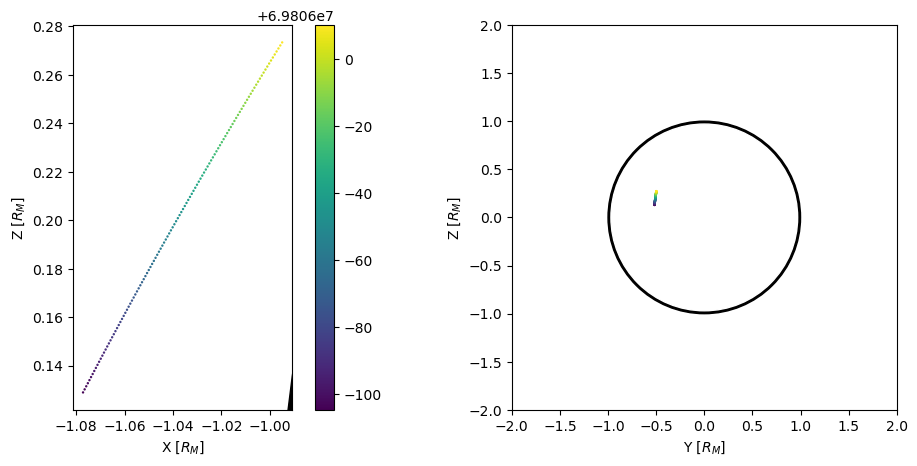

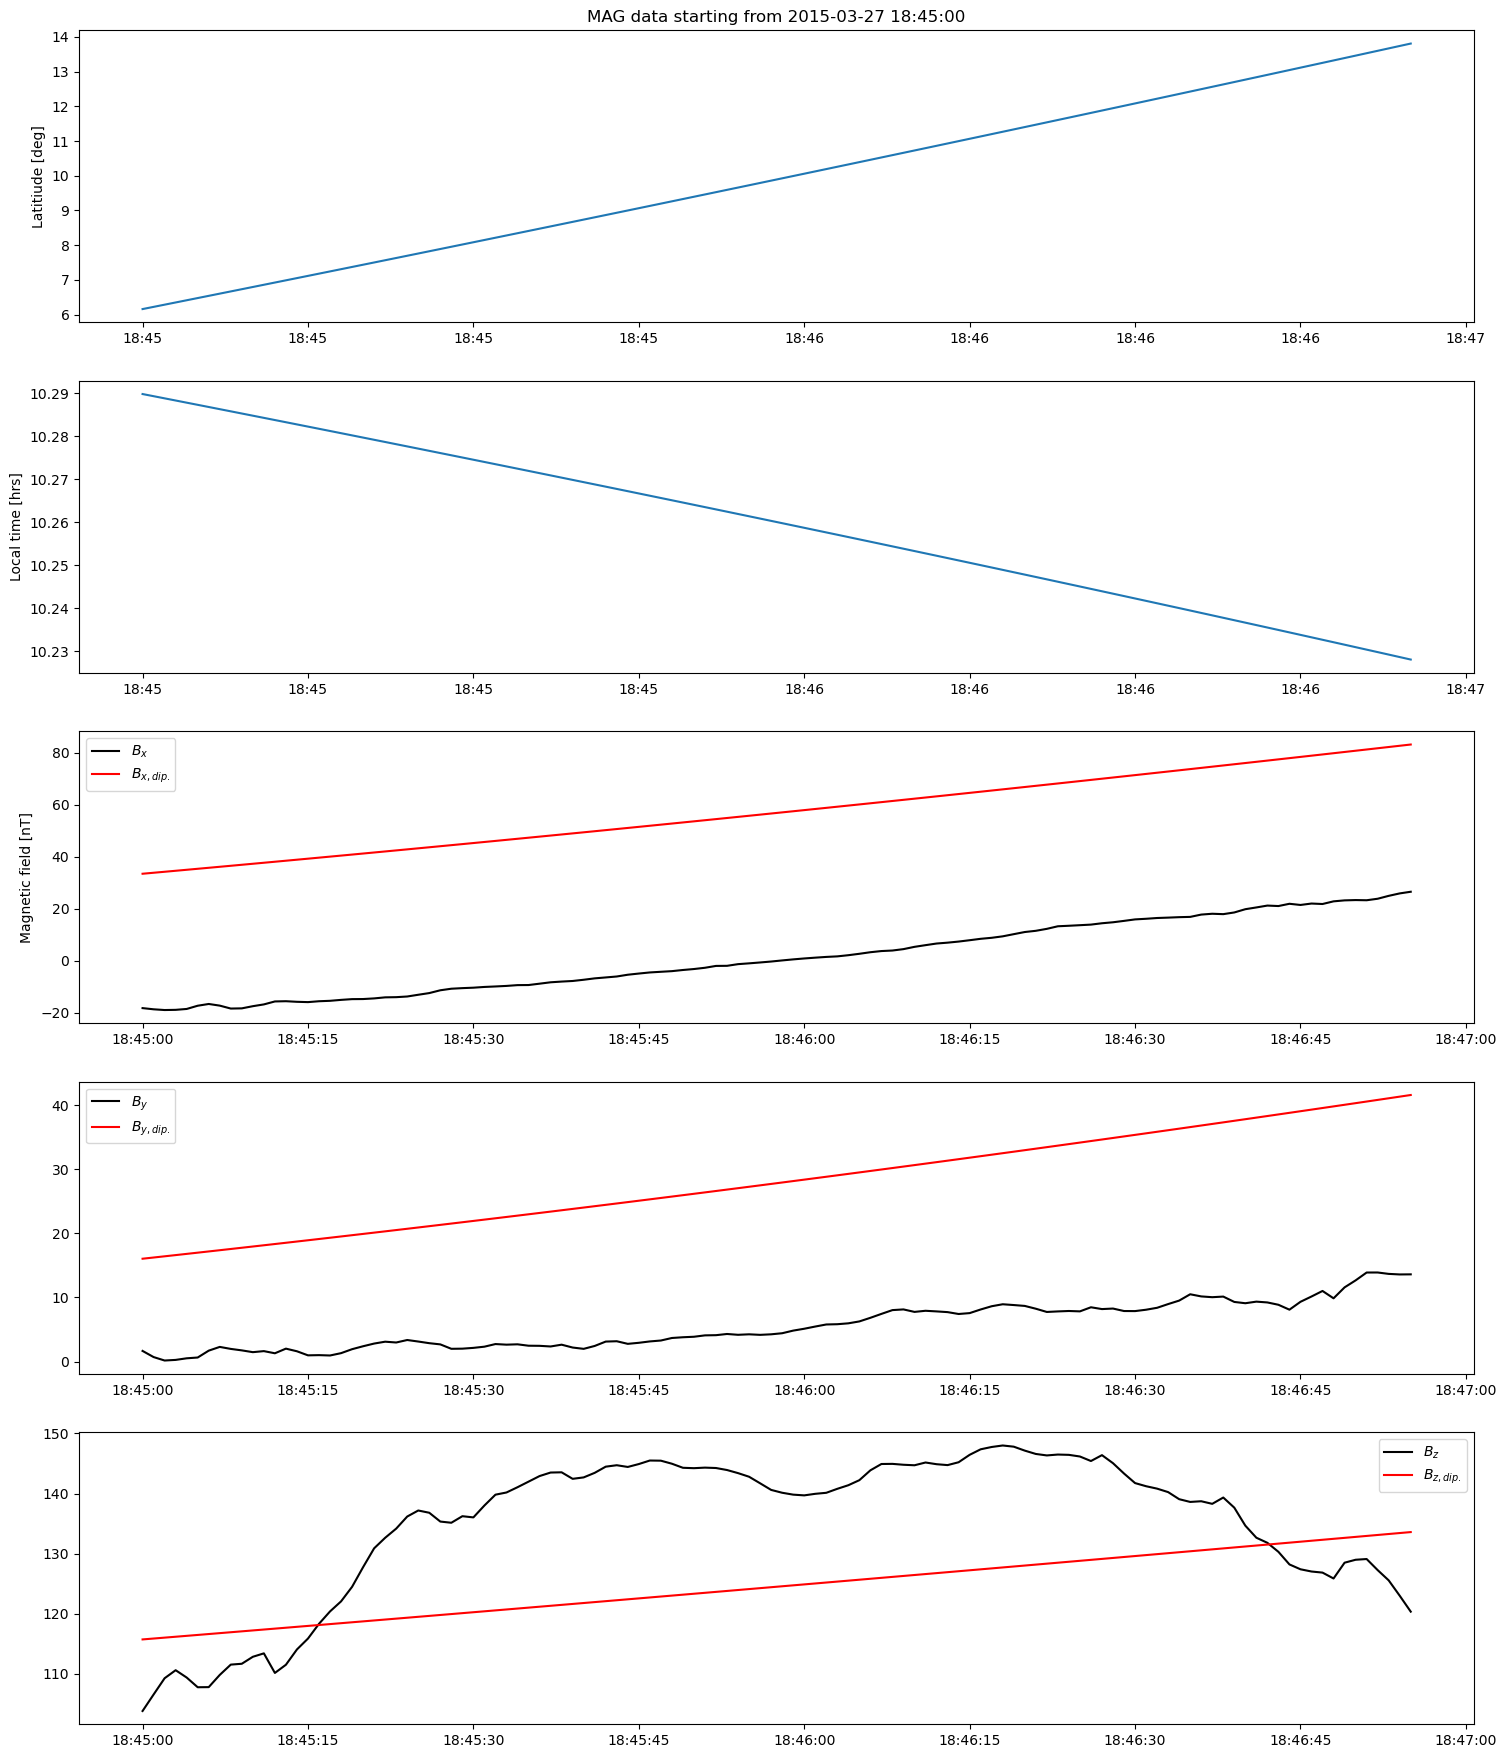

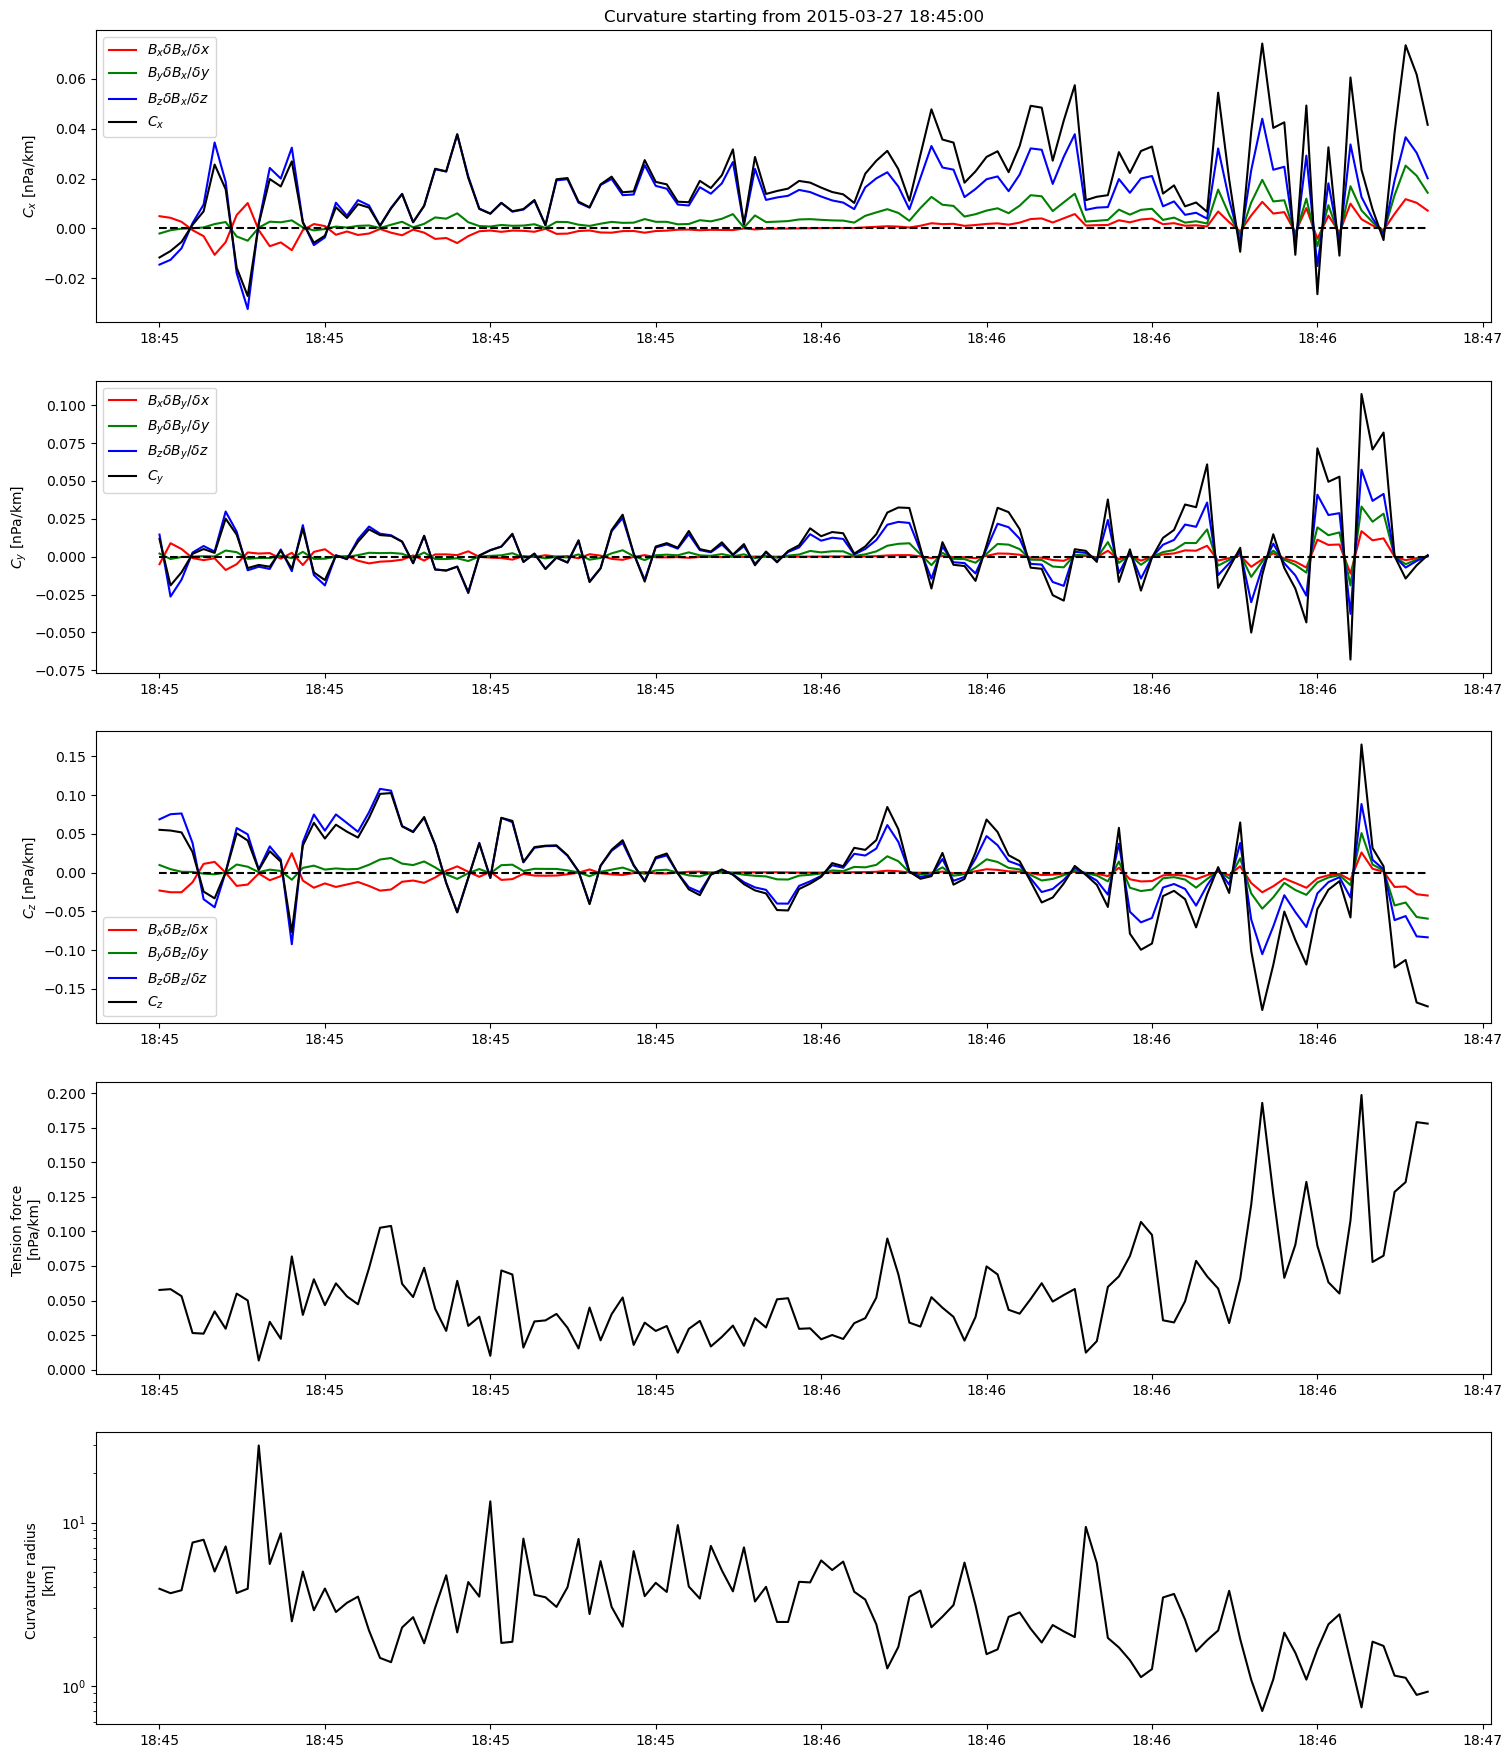

In [530]:
# User input:
dir = "/Users/atcushen/Documents/MercuryModelling/MAG/"
folder = "2015-03-27"
start_time = pd.to_datetime("2015-03-27 18:45:00")
end_time = pd.to_datetime("2015-03-27 18:46:55")

df = read_mag(str(dir+folder))
df = calculate_terms(df)

plot_orbit(df,start_time,end_time)
plot_magnetic_components(df,start_time,end_time)
plot_curvature_components(df,start_time,end_time)

In [498]:
df_slice = df[(df['timestamp']>=start_time) & (df['timestamp']<=end_time)]
df_slice['X']*0

67438   -0.0
67439   -0.0
67440   -0.0
67441   -0.0
67442   -0.0
        ... 
67674   -0.0
67675   -0.0
67676   -0.0
67677   -0.0
67678   -0.0
Name: X, Length: 241, dtype: float64